 # Team AASE takes on DeepCock
 The aim of this project is to produce a deep learning model that can take 2D slices of a 3D mesh object, and produce an accurate imitation of the object, sort of like a 3D printer! 

### Packages

In [47]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 


### Preprocessing 
The 2D slices given to us are stored in `.raw` files, our first objective is to store them as 3D arrays and combined all of them into a singular dataframe that can be utilized for analysis. We first convert the `.raw` files into `.npy` files. 

In [27]:
mesh_data = pd.read_csv('mesh_scans.csv')
mesh_data.head(6) 

,filename,original_shape,total_points,mean,std,min,max,median,point_0,point_1,...,point_990,point_991,point_992,point_993,point_994,point_995,point_996,point_997,point_998,point_999
0,scan_088.npy,"(1280, 768, 768)",754974720,20.040806,476.423220,0.0,42062.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,scan_020.npy,"(1280, 768, 768)",754974720,11.838695,245.777600,0.0,34938.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,scan_003.npy,"(1280, 768, 768)",754974720,15.833298,320.785950,0.0,38782.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,scan_015.npy,"(1280, 768, 768)",754974720,58.582146,441.118130,0.0,36239.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,scan_032.npy,"(1280, 768, 768)",754974720,1.046440,65.670166,0.0,29785.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,scan_064.npy,"(1280, 768, 768)",754974720,8.904767,197.663880,0.0,33374.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# we see that first 10 rows are useless, we only need 
#the points
mesh_points = mesh_data.iloc[:, 8:]
mesh_points

,point_0,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_990,point_991,point_992,point_993,point_994,point_995,point_996,point_997,point_998,point_999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Normalize each row to [0, 1] using min-max normalization
normalized_mesh_points = (mesh_points - mesh_points.min()) / (mesh_points.max() - mesh_points.min())
normalized_mesh_points

,point_0,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_990,point_991,point_992,point_993,point_994,point_995,point_996,point_997,point_998,point_999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
train_tensor = torch.tensor(normalized_mesh_points.values, dtype=torch.float32)  # Shape: [87, 1000]
print("Training data shape:", train_tensor.shape)  

Training data shape: torch.Size([87, 1000])


In [55]:
train_tensor = torch.where(torch.isnan(train_tensor), torch.zeros_like(train_tensor), train_tensor)
train_tensor = torch.where(torch.isinf(train_tensor), torch.zeros_like(train_tensor), train_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Start with a smaller learning rate


In [56]:
train_dataset = TensorDataset(train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Check a batch to confirm
for batch in train_loader:
    print("Batch shape:", batch[0].shape)  # Each batch should have shape [batch_size, 1000]
    break

Batch shape: torch.Size([8, 1000])


## Training our Model

In [63]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self):
        super(FullyConnectedAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1000),
            nn.Sigmoid()  # Outputs values in [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the model, loss function, and optimizer
model = FullyConnectedAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Start with a smaller learning rate


In [64]:
num_epochs = 10  # Define the number of training epochs

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        inputs = batch[0]  # Get input batch from DataLoader
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, inputs)  # Compute reconstruction loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        epoch_loss += loss.item()
    
    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/10, Loss: 0.2482
Epoch 2/10, Loss: 0.2444
Epoch 3/10, Loss: 0.2386
Epoch 4/10, Loss: 0.2293
Epoch 5/10, Loss: 0.2142
Epoch 6/10, Loss: 0.1891
Epoch 7/10, Loss: 0.1486
Epoch 8/10, Loss: 0.0917
Epoch 9/10, Loss: 0.0369
Epoch 10/10, Loss: 0.0094


In [66]:
torch.save(model.state_dict(), "autoencoder_model.pth")
# Switch the model to evaluation mode
model.eval()
with torch.no_grad():
    for i, batch in enumerate(train_loader):
        inputs = batch[0]
        reconstructed = model(inputs)
        
        # Example: Compare the first input in the batch with its reconstruction
        print("Original:", inputs[0].numpy())
        print("Reconstructed:", reconstructed[0].numpy())
        
        # Break after showing one example
        break


Original: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [68]:
model.eval()
total_loss = 0

with torch.no_grad():
    for batch in train_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        total_loss += loss.item()

average_loss = total_loss / len(train_loader)
print(f"Reconstruction Loss on Test Data: {average_loss:.4f}")


Reconstruction Loss on Test Data: 0.0039


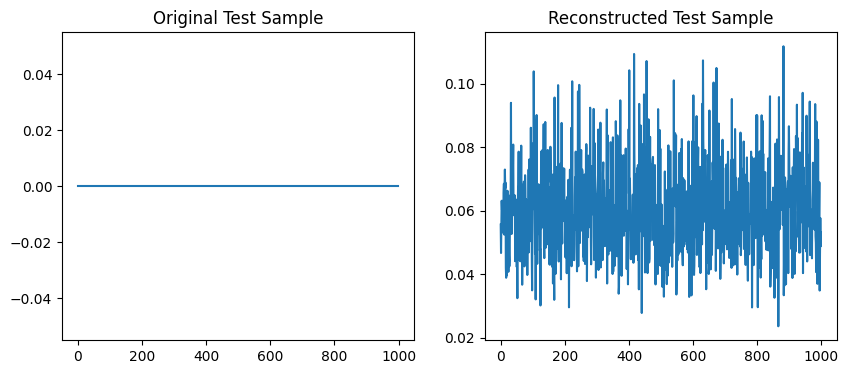

In [69]:
import matplotlib.pyplot as plt

# Visualize a sample from the testing data
with torch.no_grad():
    for batch in train_loader:
        inputs = batch[0]
        reconstructed = model(inputs)

        # Plot the first example
        original_sample = inputs[0].numpy()
        reconstructed_sample = reconstructed[0].numpy()

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(original_sample)
        plt.title("Original Test Sample")
        
        plt.subplot(1, 2, 2)
        plt.plot(reconstructed_sample)
        plt.title("Reconstructed Test Sample")
        plt.show()
        break


In [72]:
depth, height, width = 10, 10, 10

# Select a row from the DataFrame (e.g., the first row)
flattened_array = mesh_points.iloc[0].values  # Extracts the array as 1D

# Reshape to 3D
reconstructed_sample = flattened_array.reshape(depth, height, width)

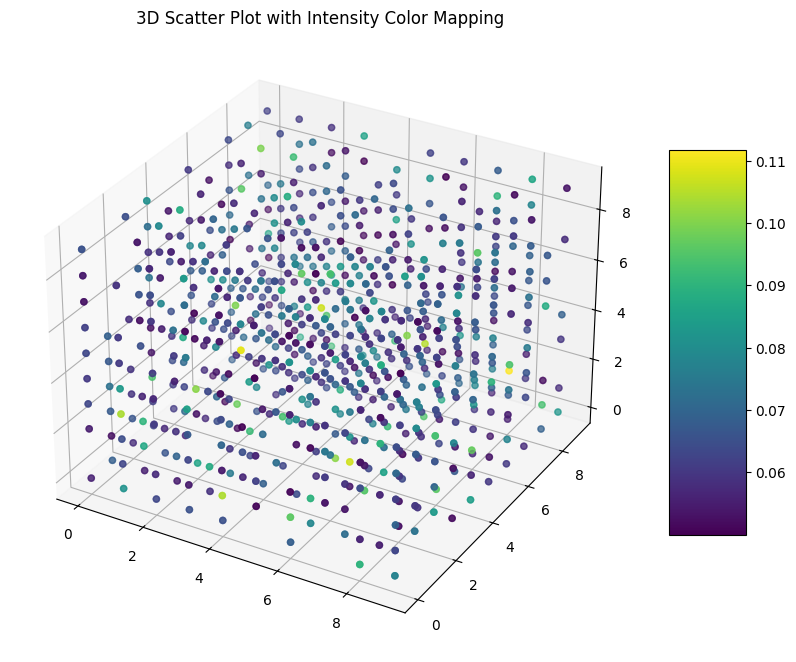

In [85]:
# Example dimensions for the 3D shape (adjust these as needed)
depth, height, width = 10, 10, 10

# Step 1: Select a row and combine columns into a single 1D array
# Assume we want to use the first row as an example
input_array = mesh_points.iloc[56].values  # Extracts values from all columns in the first row

# Step 2: Convert the 1D array to a PyTorch tensor and pass it through the model
input_tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Ensure model is in evaluation mode and pass the input through the model
model.eval()
with torch.no_grad():
    reconstructed_output = model(input_tensor).squeeze(0).numpy()  # Remove batch dimension

# Step 3: Reshape the reconstructed output to the original 3D shape
reconstructed_sample = reconstructed_output.reshape(depth, height, width)

# Step 4: Visualize the reconstructed 3D object using a threshold
threshold = 0.0000001  # Adjust threshold based on your data’s range
x, y, z = np.where(reconstructed_sample > threshold)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
intensity = reconstructed_sample.flatten()  # Flatten for color mapping

# Scatter plot with color based on intensity
x, y, z = np.where(reconstructed_sample > 0.05)  # Low threshold to capture most points
colors = reconstructed_sample[x, y, z]  # Get intensity values as colors

ax.scatter(x, y, z, c=colors, cmap='viridis', marker='o')
ax.set_title("3D Scatter Plot with Intensity Color Mapping")
plt.colorbar(ax.scatter(x, y, z, c=colors, cmap='viridis'), ax=ax, shrink=0.5, aspect=5)
plt.show()

In [77]:
print("Reconstructed sample shape:", reconstructed_sample.shape)
print("Max value in reconstructed sample:", reconstructed_sample.max())
print("Min value in reconstructed sample:", reconstructed_sample.min())


Reconstructed sample shape: (10, 10, 10)
Max value in reconstructed sample: 0.111838944
Min value in reconstructed sample: 0.023570836


In [86]:
with torch.no_grad():
    latent_representation = model.encoder(input_tensor).numpy()
    print("Latent Representation:", latent_representation)


Latent Representation: [[0.         0.         0.33673745 0.30950448 0.         0.40953192
  0.         0.2198782  0.13924913 0.2951789  0.         0.25999522
  0.         0.21412659 0.         0.         0.         0.29905334
  0.         0.         0.         0.         0.27072832 0.29240337
  0.         0.         0.19767843 0.27550787 0.29943857 0.24451704
  0.         0.         0.04418801 0.33384812 0.         0.
  0.4172626  0.39542267 0.33488247 0.         0.         0.0615401
  0.2792753  0.         0.23382717 0.         0.34308    0.
  0.29038396 0.         0.         0.         0.4148904  0.
  0.         0.07436393 0.13371035 0.32854074 0.12932365 0.22594614
  0.2467016  0.         0.         0.3555708  0.         0.13238546
  0.3032618  0.28427944 0.         0.3337455  0.25012493 0.39446375
  0.         0.         0.         0.         0.26605263 0.
  0.35156524 0.         0.         0.         0.3620513  0.16148546
  0.         0.         0.15257424 0.29076695 0.         0